In [9]:
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)

In [1]:
#Load data
dset = 11

counts_raw <- read.table(
    paste("/extra/sebastian_arnolds/analysis/trim/star_", dset, "/counts_matrix.tsv", sep=""), 
    #"/extra/sebastian_arnolds/analysis/trim/counts_matrix.tsv",
    sep="\t"
)

barcodes_vector <- as.vector(
    read.table(
        paste("/extra/sebastian_arnolds/analysis/celseq_barcodes_raw_", dset, ".txt", sep="")
        #"/extra/sebastian_arnolds/analysis/celseq_barcodes_raw_all.txt"
    )[, 1])

In [2]:
count_matrix <- as.matrix(counts_raw[, barcodes_vector])
dim(count_matrix)

[1] 17686    96

In [5]:
# Change labels for genes of interest
name_map = list(
    ENSMUSG00000062327 = "Brachyury",
    ENSMUSG00000032446 = "Eomes",
    ENSMUSG00000030544 = "Mesp1",
    ENSMUSG00000024406 = "Pou5f1",
    ENSMUSG00000012396 = "nanog",
    ENSMUSG00000096014 = "Sox1",
    ENSMUSG00000074637 = "Sox2",
    ENSMUSG00000090125 = "Pou3f1",
    ENSMUSG00000060206 = "zfp462",
    ENSMUSG00000031297 = "slc7a3"
)

for (i in 1:length(name_map)){
    old_gene_name <- names(name_map[i])
    new_gene_name <- name_map[[i]]
    message(old_gene_name, " → ", new_gene_name)
    rownames(count_matrix)[which(rownames(count_matrix) == old_gene_name)] <- new_gene_name
}

ENSMUSG00000062327 → Brachyury
ENSMUSG00000032446 → Eomes
ENSMUSG00000030544 → Mesp1
ENSMUSG00000024406 → Pou5f1
ENSMUSG00000012396 → nanog
ENSMUSG00000096014 → Sox1
ENSMUSG00000074637 → Sox2
ENSMUSG00000090125 → Pou3f1
ENSMUSG00000060206 → zfp462
ENSMUSG00000031297 → slc7a3


In [6]:
# Check our matrix and our relabelled genes
head(count_matrix)

genes_of_interest <- !grepl("^ENS", rownames(count_matrix))
goi_matrix <- count_matrix[genes_of_interest,]


message(length(barcodes_vector), " barcodes → ", 
        dim(count_matrix)[2], " cells")

message(dim(count_matrix)[1], " genes → ", 
       dim(goi_matrix)[1], " main genes of interest")

,AGTGTC,ACCATG,GAGTGA,CACTCA,CATGTC,ACAGGA,GTACCA,ACAGAC,ACGTTG,ACCAAC,⋯,ACAAGC,TGAAGG,TAACGG,AACCTC,CGTCTA,CCATAG,TTCCAG,GGACAA,ACTTCG,TTGTGC
ENSMUSG00000000001,0,3,2,2,5,7,6,2,0,9,⋯,0,5,3,3,2,2,6,0,0,4
ENSMUSG00000000028,0,0,1,0,0,0,1,0,0,2,⋯,0,2,0,0,1,1,0,0,0,1
ENSMUSG00000000031,0,0,0,0,3,2,1,1,0,0,⋯,0,0,0,1,1,7,1,57,0,0
ENSMUSG00000000037,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0,0
ENSMUSG00000000056,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000000058,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


96 barcodes → 96 cells
17686 genes → 8 main genes of interest


In [10]:
# Initialise single cell object -- we assume UMI counts from hereon out
sce <- SingleCellExperiment(assays = list(counts = count_matrix))
head(counts(sce))

,AGTGTC,ACCATG,GAGTGA,CACTCA,CATGTC,ACAGGA,GTACCA,ACAGAC,ACGTTG,ACCAAC,⋯,ACAAGC,TGAAGG,TAACGG,AACCTC,CGTCTA,CCATAG,TTCCAG,GGACAA,ACTTCG,TTGTGC
ENSMUSG00000000001,0,3,2,2,5,7,6,2,0,9,⋯,0,5,3,3,2,2,6,0,0,4
ENSMUSG00000000028,0,0,1,0,0,0,1,0,0,2,⋯,0,2,0,0,1,1,0,0,0,1
ENSMUSG00000000031,0,0,0,0,3,2,1,1,0,0,⋯,0,0,0,1,1,7,1,57,0,0
ENSMUSG00000000037,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0,0
ENSMUSG00000000056,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000000058,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [11]:
# Filter out any genes not found in any cell
genes_summed_gt_zero <- rowSums(counts(sce) > 0)
gene_names_gt_zero <- (genes_summed_gt_zero > 0)

# apply
sce_f <- sce[gene_names_gt_zero,]

# Check to see if we lost our genes of interest
genes_of_interest <- !grepl("^ENS", rownames(sce_f))

message(length(sce), " genes → ", length(sce_f), " detected genes, (", 
        length(sce) - length(sce_f), " filtered out), (",
        length(sce_f[genes_of_interest,]), " genes of interest still remaining)"
        )

sce <- sce_f # reassign

17686 genes → 17327 detected genes, (359 filtered out), (8 genes of interest still remaining)


In [12]:
# Spike-ins used?
# 
non_ENS <- !grepl("^ENS", rownames(sce))
non_goi <- rownames(sce) %in% rownames(goi_matrix)

message("Spike-ins detected = ", length(rownames(sce[non_ENS && !non_goi,])))

Spike-ins detected = 0


In [14]:
# Assign known/related groups
is.meso <- rownames(sce) %in% c("Eomes", "Brachyury", "Mesp1")
is.pluri <- rownames(sce) %in% c("Pou5f1", "nanog")
is.neuro <- rownames(sce) %in% c("Sox1", "Sox2", "Pou3f1", "zfp462", "slc7a3")

rowData(sce)$is_mesoderm <- is.meso
rowData(sce)$is_pluripotenz <- is.pluri
rowData(sce)$is_neuroectoderm <- is.neuro

# Assign known/related cell batches
colData(sce)$plate_number <- c("plate1", 96)
# can we be sure of ordering...?



FALSE  TRUE 
   57    39 

41% of cells contain less than 8000 counts


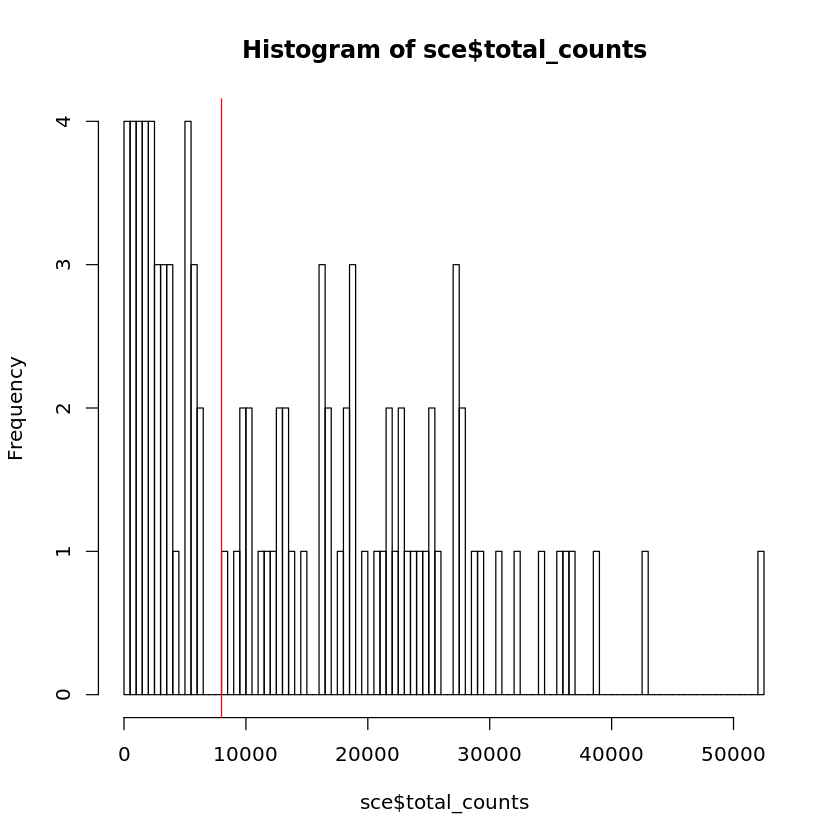

Most cells have between either 300-1700, or 5000-7000 detected genes


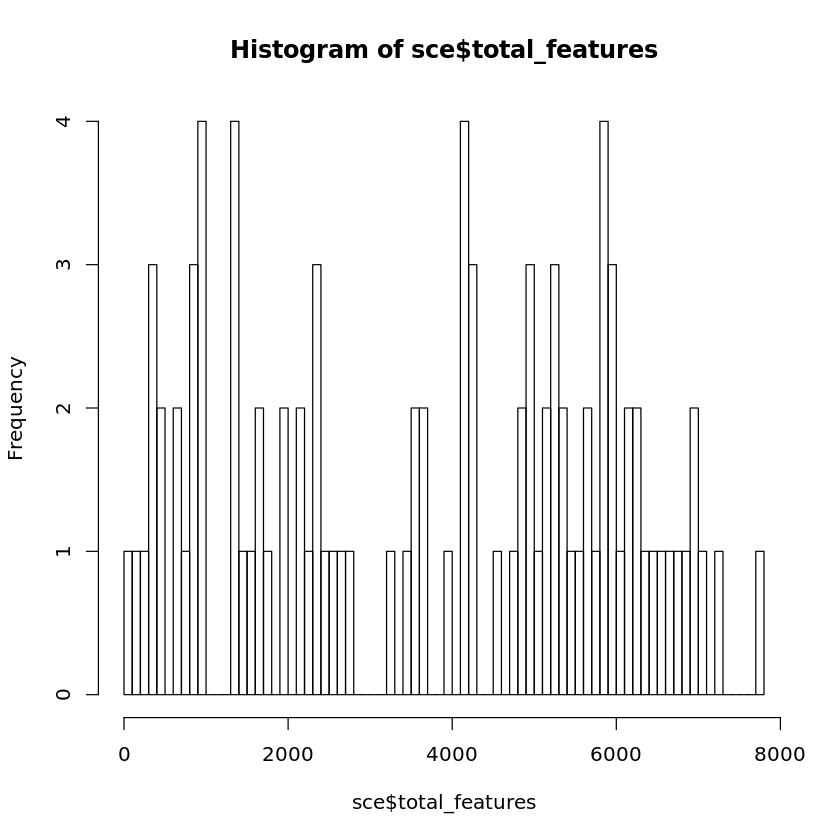

In [18]:
# Assign and calc some QC slots
sce <- calculateQCMetrics(sce)

#names(colData(sce))
lc_thresh = 8000
hist(sce$total_counts, breaks=100)
abline(v=lc_thresh, col="red")

# !! 
# For now we will assume wells with low read-depth are of poor quality. We will likely
# return to this filtering step later if we cannot find any signal in the downstream analysis.
# !!
table(sce$total_counts <= lc_thresh)
perc <- 100  * sum(sce$total_counts <= lc_thresh) / length(sce$total_counts)

message(sprintf("%.0f%% of cells contain less than %.0f counts", perc, lc_thresh))




# Let us also assume 
hist(sce$total_features, breaks = 100)
#curve(dnorm(x, 1000, 700) * 9000, col = "red", add = TRUE)
#curve(dnorm(x, 6000, 1000) * 15000, col = "blue", add = TRUE)

message("Most cells have between either 300-1700, or 5000-7000 detected genes")


#hist(sce$log10_total_counts, breaks=50)
#hist(sce$total_features, breaks=100)